## Analiza obrazów przy pomocy sieci konwolucyjnych

### 1. Zakres ćwiczeń
- Wykorzystanie konwolucyjnych sieci neuronowych (CNN) do analizy obrazu.
- Pobieranie gotowego modelu przy pomocy biblioteki Tensorflow Datasets.
- Przetwarzanie i udostępnianie danych przy pomocy Dataset API.
- Wykorzystanie gotowych modeli do uczenia transferowego.

### 2. Ćwiczenia
#### 2.1 Ładowanie danych
Do załadowania danych skorzystamy z pakietu Tensorflow Datasets, który udostępnia wiele zbiorów
przydatnych do uczenia maszynowego. Aby utrzymać względnie krótkie czasy uczenia, do ćwiczeń
będziemy używać zbioru `tf_flowers`:

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import pickle

In [3]:
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
"tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True,
with_info=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

- Możemy łatwo wyekstrahować istotne parametry zbioru:

In [5]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

- Wyświetlmy kilka przykładowych obrazów:

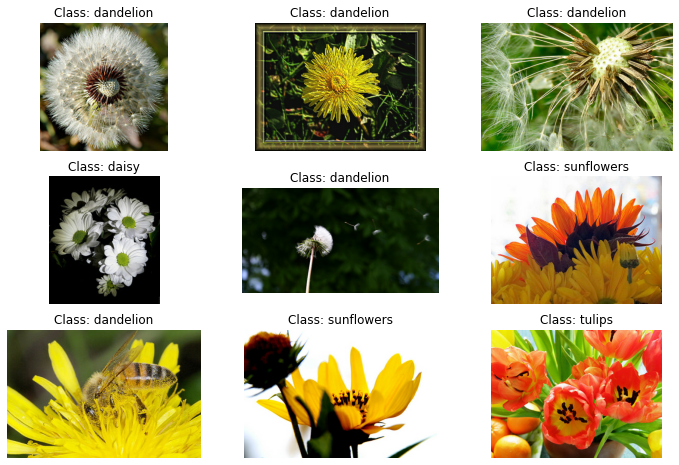

In [6]:
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

#### 2.2 Budujemy prostą sieć CNN
W tym ćwiczeniu zbudujemy sieć o nieskompikowanej strukturze.
##### 2.2.1 Przygotowanie danych
Sieć będzie przetwarzała obrazy o rozmiarze 224 × 224 pikseli, a więc pierwszym krokiem będzie
przetworzenie. Obiekty Dataset pozwalają na wykorzystanie metody map, która przy uczeniu
nadzorowanym będzie otrzymywała dwa argumenty (cechy, etykieta) i powinna zwracać je w postaci
krotki po przetworzeniu.

Najprostsza funkcja będzie po prostu skalowała obraz do pożądanego rozmiaru:

In [7]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

Aplikujemy ją do pobranych zbiorów:

In [8]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Wykorzystujemy tu dodatkowe metody Dataset API tak aby dostarczanie danych nie stało się wąskim gardłem procesu uczenia:
- `shuffle` losowo ustawia kolejność próbek w zbiorze uczącym,
- `batch` łączy próbki we wsady o podanej długości (idealnie, powinna to być wielkość miniwsadu podczas uczenia),
- `prefetch` zapewnia takie zarządzanie buforem, aby zawsze przygotowane było n próbek gotowych do pobrania (w tym przypadku chcemy, aby podczas przetwarzania miniwsadu przez algorytm uczenia zawsze czekał jeden przygotowany kolejny miniwsad).

Wyświetlmy próbkę danych po przetworzeniu:

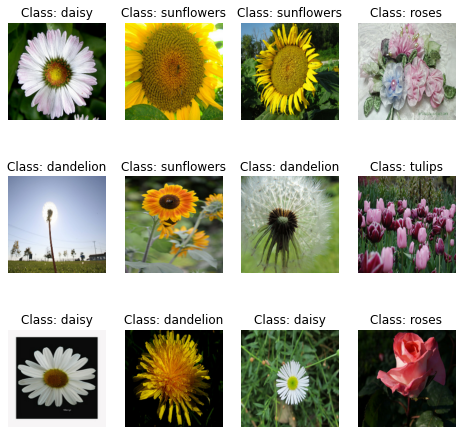

In [9]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

##### 2.2.2 Budowa sieci
Zaprojektuj prostą sieć konwolucyjną, która pozwoli na uzyskanie przyzwoitej dokładności klasyfikacji przetwarzanego zbioru.
Pamiętaj o istotnych zasadach:
1. W przypadku naszych danych, ponieważ składowe RGB pikseli mają wartości z zakresu 0–255, musimy pamiętać o normalizacji danych; można użyć do tego warstwy skalującej wartości.
2. Część wykrywająca elementy obrazu składa się z warstw konwolucyjnych, najczęściej przeplatanych warstwami zbierającymi:
     - głównymi parametrami warstw konwolucyjnych są liczba filtrów i rozmiar filtra; zazwyczaj zaczynamy od względnie niskiej liczby filtrów (np. 32) o większym rozmiarze (np. 7 × 7), aby wykryć elementarne komponenty obrazu, a na kolejnych warstwach łączymy je w bardziej złożone struktury – kombinacji jest więcej, a więc mamy coraz więcej filtrów, ale mogą być mniejszego rozmiaru (np. 3 × 3),
     - zwyczajowo na jedną warstwę konwolucyjną przypadała jedna warstwa zbierająca (zmniejszająca rozmiar „obrazu”), ale często stosujemy też kilka (np. 2) warstw konwolucyjnych bezpośrednio na sobie.
3. Po części konwolucyjnej typowo następuje część gęsta, złożona z warstw gęstych i opcjonalnie regularyzacyjnych (dropout?):
    - część gęsta musi być poprzedzona warstwą spłaszczającą dane, gdyż spodziewa się 1- wymiarowej struktury,
    - ostatnia warstwa musi być dostosowana do charakterystyki zbioru danych.


In [10]:
from functools import partial

In [11]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        activation='relu',
                        padding="SAME")

In [12]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [13]:
n_classes

5

In [14]:
model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=7,
                  input_shape=[224, 224, 3]),
    keras.layers.Rescaling(scale=1./127.5, offset=-1),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=5, activation='softmax')])

Skompiluj model z odpowiednimi parametrami, tak aby zbierana była metryka dotycząca dokładności.

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

Przeprowadź uczenie przez 10 epok.

In [16]:
history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
86/86 [==============================] - 32s 212ms/step - loss: 1.6172 - accuracy: 0.2195 - val_loss: 1.6016 - val_accuracy: 0.2377
Epoch 2/10
86/86 [==============================] - 19s 206ms/step - loss: 1.5991 - accuracy: 0.2522 - val_loss: 1.5790 - val_accuracy: 0.2940
Epoch 3/10
86/86 [==============================] - 19s 209ms/step - loss: 1.5793 - accuracy: 0.2642 - val_loss: 1.5325 - val_accuracy: 0.3612
Epoch 4/10
86/86 [==============================] - 19s 208ms/step - loss: 1.5222 - accuracy: 0.3187 - val_loss: 1.4526 - val_accuracy: 0.3630
Epoch 5/10
86/86 [==============================] - 19s 207ms/step - loss: 1.4656 - accuracy: 0.3543 - val_loss: 1.4012 - val_accuracy: 0.3666
Epoch 6/10
86/86 [==============================] - 19s 208ms/step - loss: 1.3871 - accuracy: 0.4208 - val_loss: 1.2447 - val_accuracy: 0.4574
Epoch 7/10
86/86 [==============================] - 19s 209ms/step - loss: 1.4504 - accuracy: 0.3572 - val_loss: 1.3391 - val_accuracy: 0.4138

Sprawdź jakość modelu. Model powinien zapewniać dokładność dla zbioru testowego co najmniej na poziomie ok. 60% – zbiór z kwiatami jest trudnym zadaniem dla tak prostej sieci.

In [17]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

12/12 [==============================] - 2s 137ms/step - loss: 1.2165 - accuracy: 0.5204


In [18]:
simple_cnn_acc = (acc_test, acc_valid, acc_test)

Zapisz wynik ewaluacji dla zbioru uczącego, walidacyjnego i testowego w postaci krotki
`(acc_train, acc_valid, acc_test)` do pikla simple_cnn_acc.pkl.

In [19]:
with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump(simple_cnn_acc, f)

#### 2.3 Uczenie transferowe
Tym razem wykorzystamy gotową, dużo bardziej złożoną sieć. Dzięki temu, że sieć będzie zainicjalizowana wagami, możemy znacząco skrócić czas uczenia.

Jako bazową wykorzystamy względnie nowoczesną sieć Xception. Jest ona dostępna w pakiecie `tf.keras.applications.xception`.
Wykorzystamy wcześniej już załadowane surowe zbiory danych (..._set_raw).


##### 2.3.1 Przygotowanie danych
Gotowe modele często dostarczają własnych funkcji przygotowujących wejście w sposób zapewniający optymalne przetwarzanie. Musimy więc zmienić nieco funkcję przygotowującą dane, dodając
wywołanie odpowiedniej metody.

In [20]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Zobaczmy jak tym razem wyglądają wstępnie przetworzone dane; zwróć uwagę, że ponieważ teraz wartości należą już do zakresu (−1, 1), musimy je odpowiednio przeskalować (ale w sieci nie
będziemy potrzebowali warstwy skalującej):

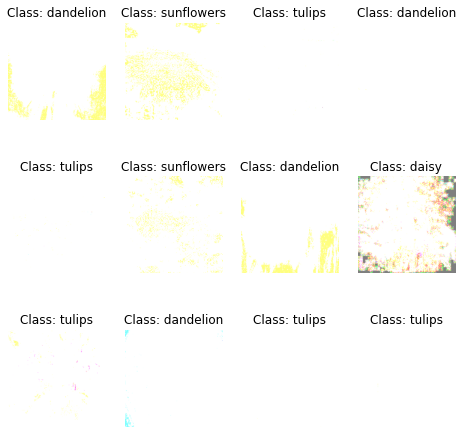

In [21]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

##### 2.3.2 Budowa sieci
Utwórz model bazowy przy pomocy odpowiedniej metody:

In [22]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [23]:
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

Wyjaśnienie:
- argument `weights` zapewnia inicjalizację wag sieci wynikami uczenia zbiorem ImageNet,
- argument `include_top` sprawi, że sieć nie będzie posiadała górnych warstw (które musimy sami dodać, gdyż są specyficzne dla danego problemu).
Możesz wyświetlić strukturę załadowanej sieci:

In [24]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

Korzystając z API funkcyjnego Keras dodaj warstwy:
- uśredniającą wartości wszystkich „pikseli”,
- wyjściową, gęstą, odpowiednią dla problemu.

In [25]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

Utwórz model korzystając z odpowiedniego konstruktora, podając jako wejścia (inputs) wejście modelu bazowego, a jako wyjścia – utworzoną warstwę wyjściową

In [26]:
model = keras.models.Model(inputs=base_model.input, outputs=output)

Przeprowadź uczenie w dwóch krokach:
1. Kilka (np. 5) iteracji, podczas których warstwy sieci bazowej będą zablokowane; ten krok jest konieczny aby zapobiec „zepsuciu” wag dostarczonych wraz z siecią bazową ze względu na spodziewane duże błędy wynikające z braku przyuczenia „nowych” warstw:

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


86/86 [==============================] - 19s 170ms/step - loss: 1.3679 - accuracy: 0.7958 - val_loss: 0.9423 - val_accuracy: 0.8566
Epoch 2/5
86/86 [==============================] - 16s 163ms/step - loss: 0.4807 - accuracy: 0.9081 - val_loss: 0.8406 - val_accuracy: 0.8695
Epoch 3/5
86/86 [==============================] - 15s 162ms/step - loss: 0.1841 - accuracy: 0.9509 - val_loss: 0.6846 - val_accuracy: 0.8879
Epoch 4/5
86/86 [==============================] - 15s 159ms/step - loss: 0.1182 - accuracy: 0.9626 - val_loss: 0.6941 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 15s 162ms/step - loss: 0.0742 - accuracy: 0.9738 - val_loss: 0.6961 - val_accuracy: 0.8787


2. Kolejne iteracje (np. 10), już z odblokowanymi do uczenia warstwami bazowymi

In [29]:
for layer in base_model.layers:
    layer.trainable = True

In [30]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


86/86 [==============================] - 61s 632ms/step - loss: 0.3603 - accuracy: 0.8884 - val_loss: 0.8507 - val_accuracy: 0.8290
Epoch 2/10
86/86 [==============================] - 55s 627ms/step - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.3179 - val_accuracy: 0.9026
Epoch 3/10
86/86 [==============================] - 56s 627ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.3014 - val_accuracy: 0.9136
Epoch 4/10
86/86 [==============================] - 56s 634ms/step - loss: 0.0203 - accuracy: 0.9960 - val_loss: 0.3722 - val_accuracy: 0.9007
Epoch 5/10
86/86 [==============================] - 55s 625ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.3334 - val_accuracy: 0.9210
Epoch 6/10
86/86 [==============================] - 55s 620ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.3839 - val_accuracy: 0.9301
Epoch 7/10
86/86 [==============================] - 56s 633ms/step - loss: 0.0096 - accuracy: 0.9967 - val_loss: 0.3938 - val_accuracy: 0.9246
Epoch 8/10

Aby ograniczyć czas uczenia (i oceniania), ustaw niezbyt wysoką liczbę iteracji w drugiej fazie.
Przeprowadź ewaluację modelu analogicznie do tej w poprzednim zadaniu.

In [31]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

12/12 [==============================] - 2s 193ms/step - loss: 0.3198 - accuracy: 0.9264


In [32]:
xception_acc = (acc_test, acc_valid, acc_test)

Zapisz wynik ewaluacji dla zbioru uczącego, walidacyjnego i testowego w postaci krotki
`(acc_train, acc_valid, acc_test)` do ***pikla xception_acc.pkl***.

In [33]:
with open('xception_acc.pkl', 'wb') as f:
    pickle.dump(xception_acc, f)